In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/land-cover-classification-master')

In [ ]:
!pip install tensorflow rasterio numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 104.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import rasterio
import pickle
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

print("✅ All libraries loaded!")

✅ All libraries loaded!


In [ ]:
# File paths - Mount your Drive first if needed
image_path = "/content/drive/MyDrive/land-cover-classification-master/data/19920612_AVIRIS_IndianPine_Site3.tif"
label_path = "/content/drive/MyDrive/land-cover-classification-master/data/19920612_AVIRIS_IndianPine_Site3_gr.tif"

# Load hyperspectral image
with rasterio.open(image_path) as src:
    image = src.read()  # Shape: (Bands, H, W)
image = np.transpose(image, (1, 2, 0))  # (H, W, Bands)

# Load ground truth
with rasterio.open(label_path) as src:
    labels = src.read(1)  # (H, W)

# Standardize image
scaler = StandardScaler()
h, w, b = image.shape
image_reshaped = image.reshape(-1, b)
image_std = scaler.fit_transform(image_reshaped).reshape(h, w, b)

# PCA reduction to 50 components
NUM_COMPONENTS = 50
pca = PCA(n_components=NUM_COMPONENTS)
image_pca = pca.fit_transform(image_std.reshape(-1, b)).reshape(h, w, NUM_COMPONENTS)

print("Image shape after PCA:", image_pca.shape)

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Image shape after PCA: (145, 145, 50)


In [ ]:
PATCH_SIZE = 5
half = PATCH_SIZE // 2
X, y = [], []

for i in range(half, h - half):
    for j in range(half, w - half):
        if labels[i, j] > 0:
            patch = image_pca[i-half:i+half+1, j-half:j+half+1, :]
            X.append(patch)
            y.append(labels[i, j] - 1)

X = np.array(X)
y = np.array(y)
y = to_categorical(y, num_classes=17)

print(f"Extracted {X.shape[0]} patches of shape {X.shape[1:]}")

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Save test set
with open("/content/drive/MyDrive/land-cover-classification-master/test_data_3d.pkl", "wb") as f:
    pickle.dump((X_test, y_test), f)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Extracted 10195 patches of shape (5, 5, 50)
Train: (7136, 5, 5, 50), Val: (1529, 5, 5, 50), Test: (1530, 5, 5, 50)


In [ ]:
def build_3d_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),

        layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_3d_cnn((PATCH_SIZE, PATCH_SIZE, NUM_COMPONENTS, 1), 17)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 5, 5, 50, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5, 5, 50, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 2, 2, 25, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 2, 2, 25, 64)   │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 2, 25, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 1, 1, 12, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 17)             │         4,369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257,873 (1007.32 KB)

 Trainable params: 257,681 (1006.57 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# Expand dimensions for 3D CNN input
X_train_exp = np.expand_dims(X_train, axis=-1)
X_val_exp = np.expand_dims(X_val, axis=-1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(
    X_train_exp, y_train,
    validation_data=(X_val_exp, y_val),
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

model.save("/content/drive/MyDrive/land-cover-classification-master/Models/3D CNN/3D_CNN_Model.h5")
print("✅ Model trained and saved!")

Epoch 1/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4984 - loss: 1.7692 - val_accuracy: 0.7613 - val_loss: 0.8354 - learning_rate: 0.0010
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8075 - loss: 0.5380 - val_accuracy: 0.9052 - val_loss: 0.3091 - learning_rate: 0.0010
Epoch 3/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9103 - loss: 0.2453 - val_accuracy: 0.9346 - val_loss: 0.1921 - learning_rate: 0.0010
Epoch 4/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9486 - loss: 0.1518 - val_accuracy: 0.9451 - val_loss: 0.1506 - learning_rate: 0.0010
Epoch 5/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9627 - loss: 0.1104 - val_accuracy: 0.9738 - val_loss: 0.0845 - learning_rate: 0.0010
Epoch 6/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9710 - loss: 0.0874 - val_accuracy: 0.9836 - val_loss: 0.0604 - learning_rate: 0.0010
Epoch 7/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9774 - loss: 0

✅ Model trained and saved!


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import pickle
from tensorflow.keras.models import load_model

# 📥 Load test data and labels
with open("test_data_3d.pkl", "rb") as f:
    X_test, y_test = pickle.load(f)

print(f"✅ Test data loaded: {X_test.shape}, Labels: {y_test.shape}")

# 🎯 Convert one-hot to class indices
y_test_labels = np.argmax(y_test, axis=1)

# 🧠 Load model
model = load_model("/content/drive/MyDrive/land-cover-classification-master/Models/3D CNN/3D_CNN_Model.h5")
print("✅ 3D CNN model loaded!")

# 📊 Predict
y_pred_probs = model.predict(X_test, batch_size=32)
y_pred = np.argmax(y_pred_probs, axis=1)

# ✅ Accuracy
test_accuracy = accuracy_score(y_test_labels, y_pred)
print(f"🎯 Test Accuracy: {test_accuracy:.4f}")

# 📄 Classification Report
report = classification_report(y_test_labels, y_pred)
print("📄 Classification Report:\n", report)


✅ Test data loaded: (1530, 5, 5, 50), Labels: (1530, 17)


✅ 3D CNN model loaded!
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
🎯 Test Accuracy: 0.9948
📄 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00       215
           2       1.00      0.98      0.99       117
           3       1.00      1.00      1.00        35
           4       1.00      1.00      1.00        71
           5       1.00      0.99      1.00       112
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00        74
           8       1.00      0.67      0.80         3
           9       0.98      1.00      0.99       145
          10       1.00      0.99      1.00       364
          11       1.00      1.00      1.00        92
          12       1.00      1.00      1.00        32
          13       0.99      0.99      0.99       194
          14       0.96      1.00      0.98        50
          15       1.00

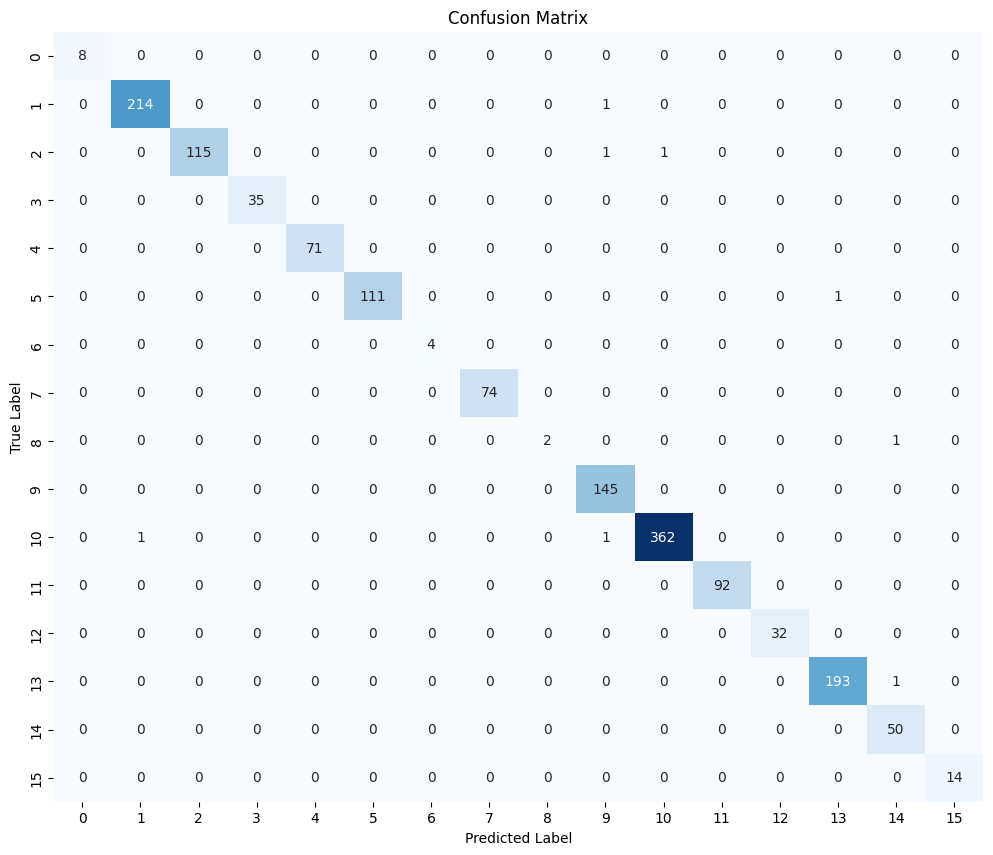

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00       215
           2       1.00      0.98      0.99       117
           3       1.00      1.00      1.00        35
           4       1.00      1.00      1.00        71
           5       1.00      0.99      1.00       112
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00        74
           8       1.00      0.67      0.80         3
           9       0.98      1.00      0.99       145
          10       1.00      0.99      1.00       364
          11       1.00      1.00      1.00        92
          12       1.00      1.00      1.00        32
          13       0.99      0.99      0.99       194
          14       0.96      1.00      0.98        50
          15       1.00      1.00      1.00        14

    accuracy                           0.99      1530
 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 🔁 Ensure one-hot → class index conversion
y_true = np.argmax(y_test, axis=1)

# 🧠 Convert predicted probs to class indices only if needed
if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
    y_pred_classes = np.argmax(y_pred, axis=1)
else:
    y_pred_classes = y_pred.astype(int)

# 📉 Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# 🎨 Plotting
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 🧾 Classification Report
print("📋 Classification Report:")
print(classification_report(y_true, y_pred_classes))


In [ ]:
import numpy as np
import rasterio
import pickle
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random

# ------------------------------------
# 🔹 Load Hyperspectral Image & Labels
# ------------------------------------
image_path = "/content/drive/MyDrive/land-cover-classification-master/data/19920612_AVIRIS_IndianPine_Site3.tif"
label_path = "/content/drive/MyDrive/land-cover-classification-master/data/19920612_AVIRIS_IndianPine_Site3_gr.tif"

with rasterio.open(image_path) as src:
    image = src.read()
image = np.transpose(image, (1, 2, 0))  # (H, W, Bands)

with rasterio.open(label_path) as src:
    labels = src.read(1)  # (H, W)

# ------------------------------------
# 🔹 Standardize + PCA
# ------------------------------------
h, w, b = image.shape
scaler = StandardScaler()
image_reshaped = image.reshape(-1, b)
image_std = scaler.fit_transform(image_reshaped).reshape(h, w, b)

NUM_COMPONENTS = 50
pca = PCA(n_components=NUM_COMPONENTS)
image_pca = pca.fit_transform(image_std.reshape(-1, b)).reshape(h, w, NUM_COMPONENTS)

# ------------------------------------
# 🔹 Patch Extraction
# ------------------------------------
PATCH_SIZE = 5
half = PATCH_SIZE // 2
X, y, coords = [], [], []

for i in range(half, h - half):
    for j in range(half, w - half):
        if labels[i, j] > 0:
            patch = image_pca[i-half:i+half+1, j-half:j+half+1, :]
            X.append(patch)
            y.append(labels[i, j] - 1)
            coords.append((i, j))

X = np.array(X)
y = np.array(y)
coords = np.array(coords)
X = X[..., np.newaxis]  # Add channel dimension
y = to_categorical(y, num_classes=17)

# ------------------------------------
# 🔹 Proper Train/Val/Test Split (No Leakage)
# ------------------------------------
X_train, X_temp, y_train, y_temp, coords_train, coords_temp = train_test_split(
    X, y, coords, test_size=0.3, stratify=y, random_state=42)

X_val, X_test, y_val, y_test, coords_val, coords_test = train_test_split(
    X_temp, y_temp, coords_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Save test data and coords
with open("/content/drive/MyDrive/land-cover-classification-master/test_data_3d_updated.pkl", "wb") as f:
    pickle.dump((X_test, y_test), f)

with open("/content/drive/MyDrive/land-cover-classification-master/test_coords_3d_updated.pkl", "wb") as f:
    pickle.dump(coords_test, f)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# ------------------------------------
# 🔹 3D CNN Architecture
# ------------------------------------
def build_3d_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling3D((2, 2, 2)),

        layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling3D((2, 2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_3d_cnn((PATCH_SIZE, PATCH_SIZE, NUM_COMPONENTS, 1), 17)
model.summary()

# ------------------------------------
# 🔹 Training with Callbacks
# ------------------------------------
early_stop = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

# ------------------------------------
# 🔹 Save Final Model
# ------------------------------------
model.save("/content/drive/MyDrive/land-cover-classification-master/Models/3D CNN/3d_CNN_updated.h5")


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Train: (7136, 5, 5, 50, 1), Val: (1529, 5, 5, 50, 1), Test: (1530, 5, 5, 50, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_2 (Conv3D)               │ (None, 5, 5, 50, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 5, 50, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 2, 25, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 2, 2, 25, 64)   │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 25, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 1, 12, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 17)             │         4,369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257,873 (1007.32 KB)

 Trainable params: 257,681 (1006.57 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
223/223 - 7s - 30ms/step - accuracy: 0.6138 - loss: 1.1586 - val_accuracy: 0.7436 - val_loss: 0.8791 - learning_rate: 1.0000e-03
Epoch 2/50
223/223 - 1s - 6ms/step - accuracy: 0.8404 - loss: 0.4455 - val_accuracy: 0.8875 - val_loss: 0.3166 - learning_rate: 1.0000e-03
Epoch 3/50
223/223 - 1s - 5ms/step - accuracy: 0.9147 - loss: 0.2555 - val_accuracy: 0.9091 - val_loss: 0.2533 - learning_rate: 1.0000e-03
Epoch 4/50
223/223 - 1s - 6ms/step - accuracy: 0.9430 - loss: 0.1693 - val_accuracy: 0.9581 - val_loss: 0.1187 - learning_rate: 1.0000e-03
Epoch 5/50
223/223 - 1s - 4ms/step - accuracy: 0.9616 - loss: 0.1159 - val_accuracy: 0.9523 - val_loss: 0.1471 - learning_rate: 1.0000e-03
Epoch 6/50
223/223 - 1s - 6ms/step - accuracy: 0.9727 - loss: 0.0812 - val_accuracy: 0.9817 - val_loss: 0.0733 - learning_rate: 1.0000e-03
Epoch 7/50
223/223 - 1s - 6ms/step - accuracy: 0.9780 - loss: 0.0647 - val_accuracy: 0.9686 - val_loss: 0.0834 - learning_rate: 1.0000e-03
Epoch 8/50
223/223 - 1s - 

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Test Accuracy: 99.48%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.99      1.00      0.99       215
           2       1.00      1.00      1.00       117
           3       1.00      1.00      1.00        35
           4       1.00      1.00      1.00        71
           5       1.00      1.00      1.00       112
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00        74
           8       1.00      1.00      1.00         3
           9       0.97      1.00      0.99       145
          10       1.00      0.98      0.99       364
          11       0.99      0.99      0.99        92
          12       1.00      1.00      1.00        32
          13       1.00      1.00      1.00       194
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        

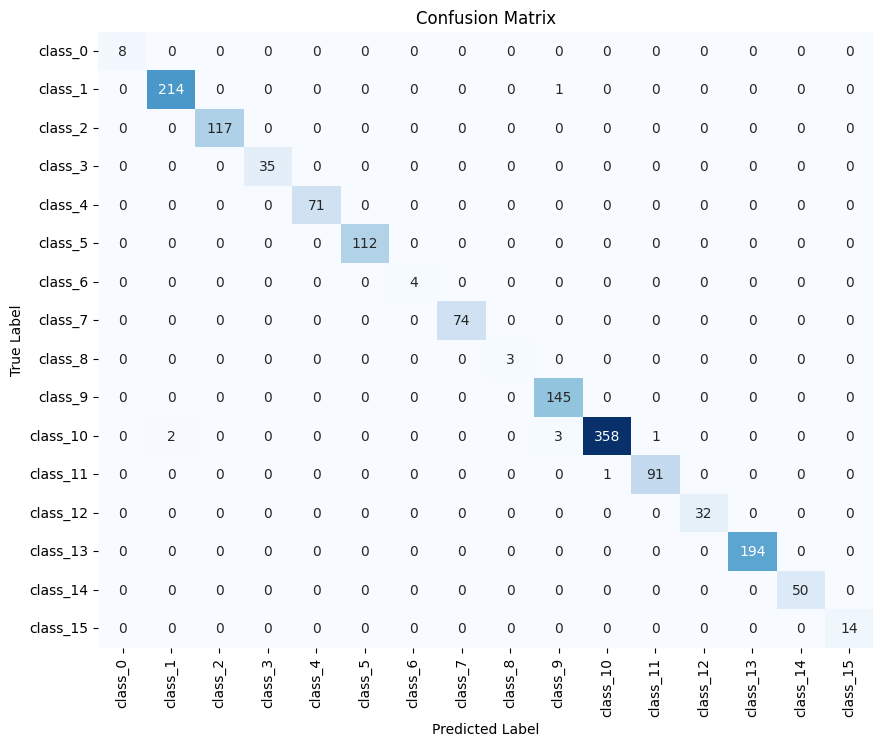

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load the trained model
model = load_model("/content/drive/MyDrive/land-cover-classification-master/Models/3D CNN/3d_CNN_updated.h5")

# Load the test data and coordinates
with open("/content/drive/MyDrive/land-cover-classification-master/test_data_3d_updated.pkl", "rb") as f:
    X_test, y_test = pickle.load(f)

with open("/content/drive/MyDrive/land-cover-classification-master/test_coords_3d_updated.pkl", "rb") as f:
    coords_test = pickle.load(f)

# Test the model
y_pred = model.predict(X_test, batch_size=32)

# Convert predictions from one-hot encoded to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Evaluate accuracy
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Classification report for detailed metrics
report = classification_report(y_test_labels, y_pred_labels)
print("Classification Report:")
print(report)

# Assuming y_test_labels and y_pred_labels are your true and predicted labels respectively
# Replace these variables with your actual test data and predictions
# y_test_labels = [true labels for your test data]
# y_pred_labels = [predicted labels from your model]

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# List of class names (replace with actual class names)
class_names = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4',
               'class_5', 'class_6', 'class_7', 'class_8', 'class_9',
               'class_10', 'class_11', 'class_12', 'class_13', 'class_14',
               'class_15']  # Replace with your actual class names

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## Fine tuning on salinas A

In [ ]:
import numpy as np
import scipy.io as sio
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle

# ------------------------------------
# 🔹 Load Salinas Hyperspectral Image & Labels
# ------------------------------------
salinas_data = sio.loadmat('/content/drive/MyDrive/land-cover-classification-master/data/Salinas_corrected.mat')
salinas_gt = sio.loadmat('/content/drive/MyDrive/land-cover-classification-master/data/Salinas_gt.mat')

image = salinas_data['salinas_corrected']  # Hyperspectral image
labels = salinas_gt['salinas_gt']  # Ground truth labels

# ------------------------------------
# 🔹 Standardize + PCA
# ------------------------------------
h, w, b = image.shape
scaler = StandardScaler()
image_reshaped = image.reshape(-1, b)
image_std = scaler.fit_transform(image_reshaped).reshape(h, w, b)

NUM_COMPONENTS = 50  # Same number of components as used in the Indian Pines dataset
pca = PCA(n_components=NUM_COMPONENTS)
image_pca = pca.fit_transform(image_std.reshape(-1, b)).reshape(h, w, NUM_COMPONENTS)

# ------------------------------------
# 🔹 Patch Extraction (Same as Indian Pines)
# ------------------------------------
PATCH_SIZE = 5
half = PATCH_SIZE // 2
X, y, coords = [], [], []

for i in range(half, h - half):
    for j in range(half, w - half):
        if labels[i, j] > 0:  # Ignore background
            patch = image_pca[i-half:i+half+1, j-half:j+half+1, :]
            X.append(patch)
            y.append(labels[i, j] - 1)  # 0-based indexing
            coords.append((i, j))

X = np.array(X)[..., np.newaxis]  # Shape: (N, 5, 5, 50, 1)
y = to_categorical(np.array(y), num_classes=16)
coords = np.array(coords)

# ------------------------------------
# 🔹 Proper Train/Val/Test Split (No Leakage)
# ------------------------------------
X_train, X_temp, y_train, y_temp, coords_train, coords_temp = train_test_split(
    X, y, coords, test_size=0.3, stratify=y, random_state=42)

X_val, X_test, y_val, y_test, coords_val, coords_test = train_test_split(
    X_temp, y_temp, coords_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Save test data and coords for evaluation later
with open("/content/drive/MyDrive/land-cover-classification-master/test_data_3d_salinas.pkl", "wb") as f:
    pickle.dump((X_test, y_test), f)

with open("/content/drive/MyDrive/land-cover-classification-master/test_coords_3d_salinas.pkl", "wb") as f:
    pickle.dump(coords_test, f)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# ------------------------------------
# 🔹 Load Pre-trained 3D CNN Sequential Model
# ------------------------------------
pretrained_model = tf.keras.models.load_model(
    '/content/drive/MyDrive/land-cover-classification-master/Models/3D CNN/3d_CNN_updated.h5'
)

# ------------------------------------
# 🔹 Modify Output Layer for Salinas (16 classes)
# ------------------------------------
new_model = models.Sequential()

# Copy all layers except the last one
for layer in pretrained_model.layers[:-1]:
    layer.trainable = False  # Optional: freeze layers
    new_model.add(layer)

# Add new output layer
new_model.add(layers.Dense(16, activation='softmax'))  # 16 classes for Salinas

# Compile the model
new_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Confirm structure
new_model.summary()

# ------------------------------------
# 🔹 Fine-Tune the Model
# ------------------------------------
early_stop = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5)

history = new_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

# ------------------------------------
# 🔹 Save Fine-Tuned Model
# ------------------------------------
new_model.save('/content/drive/MyDrive/land-cover-classification-master/Models/3D CNN/3d_CNN_fine_tuned_salinas.h5')


Train: (37359, 5, 5, 50, 1), Val: (8005, 5, 5, 50, 1), Test: (8006, 5, 5, 50, 1)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_2 (Conv3D)               │ (None, 5, 5, 50, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 5, 50, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 2, 25, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 2, 2, 25, 64)   │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 25, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 1, 12, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,504 (990.25 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 253,504 (990.25 KB)

Epoch 1/50
1168/1168 - 7s - 6ms/step - accuracy: 0.2749 - loss: 5.6763 - val_accuracy: 0.6601 - val_loss: 0.8733 - learning_rate: 1.0000e-04
Epoch 2/50
1168/1168 - 5s - 4ms/step - accuracy: 0.5496 - loss: 1.8857 - val_accuracy: 0.8336 - val_loss: 0.3851 - learning_rate: 1.0000e-04
Epoch 3/50
1168/1168 - 4s - 3ms/step - accuracy: 0.6879 - loss: 0.9840 - val_accuracy: 0.8924 - val_loss: 0.2808 - learning_rate: 1.0000e-04
Epoch 4/50
1168/1168 - 6s - 5ms/step - accuracy: 0.7738 - loss: 0.6153 - val_accuracy: 0.9056 - val_loss: 0.2522 - learning_rate: 1.0000e-04
Epoch 5/50
1168/1168 - 4s - 4ms/step - accuracy: 0.8189 - loss: 0.4647 - val_accuracy: 0.9176 - val_loss: 0.2352 - learning_rate: 1.0000e-04
Epoch 6/50
1168/1168 - 3s - 3ms/step - accuracy: 0.8476 - loss: 0.3913 - val_accuracy: 0.9168 - val_loss: 0.2249 - learning_rate: 1.0000e-04
Epoch 7/50
1168/1168 - 5s - 4ms/step - accuracy: 0.8653 - loss: 0.3469 - val_accuracy: 0.9235 - val_loss: 0.2159 - learning_rate: 1.0000e-04
Epoch 8/50
11

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/land-cover-classification-master/Models/3D CNN/3d_CNN_fine_tuned_salinas.h5')
import pickle

# Load test data and labels for Salinas
with open("/content/drive/MyDrive/land-cover-classification-master/test_data_3d_salinas.pkl", "rb") as f:
    X_test_salinas, y_test_salinas = pickle.load(f)

# Evaluate
loss_salinas, acc_salinas = model.evaluate(X_test_salinas, y_test_salinas, verbose=2)
print(f"📊 Salinas Test Accuracy: {acc_salinas * 100:.2f}%")

251/251 - 3s - 11ms/step - accuracy: 0.9337 - loss: 0.1637
📊 Salinas Test Accuracy: 93.37%
